## Create the two loops

In [2]:
!pip install numpy

/bin/bash: /home/mehdii/projects/def-vidalthi/mehdii/3DPU_Plateau_Problem/env_gurobi_HZ/bin/pip: /home/mehdii/env_gurobi_HZ/bin/python: bad interpreter: No such file or directory


In [3]:
import sys
import sys
import os
ROOT  = "../"
# Add current working directory to sys.path
sys.path.append(ROOT)
sys.path.append("/home/mehdii/projects/def-vidalthi/mehdii/3DPU_Plateau_Problem/")
from PointList import *
%matplotlib widget 
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from _3DLoops._3dpu_using_dfs import *
from Block_edges.block_edges import *
import sys
sys.path.append("/home/mehdii/projects/def-vidalthi/mehdii/3DPU_Plateau_Problem/MIP_constraints/Python/")
from CreatingCycles import *


with open('/home/mehdii/projects/def-vidalthi/mehdii/3DPU_Plateau_Problem/Results/ph_loops.pkl',"rb") as file:
    C = pickle.load(file)

## The two loops

In [4]:
def singular_loop(r,O, num_points):
    xo,yo,zo = O
    points = PointList()
    for n in tqdm(range(num_points)):
        theta = n * 2 * math.pi / num_points
        x = r * math.cos(theta) + xo
        y = r * math.sin(theta) + yo
        points.add_point((x,y,zo))
    return points

## Fill in the said loop

In [62]:
def create_loop(h,r):
    points1 = singular_loop(r,(0,0,0.5), 100)
    points2 = singular_loop(r,(0,0,h + 0.5), 100)
    loops = [points1,points2]
    List_edges = []
    for loop in loops:
        M = Edge_Flipping(loop,10*len(loop.points))
        M.create_quadrilaterals()
        M.split_quadrilateral()
        M.canonic_representation_from_mesh()
        M.clean_triangles()
        M.fill_edges()
        M.update_weights()
        M.mapping = [np.array(o) for o in M.mapping]
        E = Block_edges(M.triangles,M.mapping)
        E.block_all_the_edges()
        List_edges.append(E.blocked_edges)

    Edges = []
    for list_edges in tqdm(List_edges):
        for edge in list_edges: 
            Edges.append([list(edge[0]),list(edge[1])])

            
    Edges = set([tuple((tuple(edge[0]),tuple(edge[1]))) for edge in Edges])
    Edges = list(Edges)
    return Edges 

In [5]:
from Plateau_Problem.Triangulation_Meshing.tests.definir_cycle import transform_res_to_point
def points(cycle):
    points = PointList()
    for res in cycle:
        points.add_point(transform_res_to_point(C.mapping[res]))
    return points

def fill_cycle(cycle):
    points = PointList()
    for res in cycle:
        points.add_point(transform_res_to_point(C.mapping[res]))
    M = Edge_Flipping(points,10*len(points.points))
    M.create_quadrilaterals()
    M.split_quadrilateral()
    M.canonic_representation_from_mesh()
    M.clean_triangles()
    M.fill_edges()
    M.update_weights()
    M.mapping = [np.array(o) for o in M.mapping]
    E = Block_edges(M.triangles,M.mapping)
    E.block_all_the_edges()
    Edges = (E.blocked_edges)
    return Edges,M




[[1277956, 589540, 133, 1273605],
 [1671176, 995348, 1671187],
 [1802251,
  459745,
  1125602,
  459769,
  464868,
  470116,
  1816542,
  1147100,
  470089,
  464844,
  459746,
  1125560,
  459727,
  464829,
  1809394,
  464828,
  1802214],
 [1343502,
  67652,
  1350133,
  73653,
  79606,
  678061,
  79635,
  671239,
  73706,
  1350191,
  73705,
  1356732,
  79660,
  678097,
  678059,
  1363200,
  678060,
  85669,
  684860,
  1369756,
  91716,
  97784,
  698570,
  1382973,
  698571,
  698545,
  1382932,
  97747,
  691658,
  97786,
  1382952,
  103685,
  1389639,
  1389638,
  705474,
  705434,
  109640,
  115484,
  1402792,
  121315,
  1409436,
  127102,
  1416116,
  732948,
  1416079,
  1416080,
  132707,
  1422783,
  138346,
  746969,
  138370,
  740088,
  132775,
  1416144,
  1416145,
  127129,
  726243,
  726275,
  1409521,
  121404,
  1402891,
  121405,
  1409522,
  726305,
  127216,
  132845,
  740212,
  1422966,
  1422967,
  740213,
  1422939,
  1422940],
 [1310736, 623619, 31017

In [99]:
Dict = {len(c):c for c in C.open_paths}
cycle = Dict[90]
Edges,M = fill_cycle(cycle)
triangles = M.triangles
mapping = M.mapping





s is 4


100%|██████████| 451/451 [00:00<00:00, 490568.23it/s]


In [97]:
import gurobipy as gp
from gurobipy import Model, GRB, quicksum

Marked_edges = []
Blocked_edges = Edges
GC = Graph_Cycles(Blocked_edges, Marked_edges)
G = GraphGrid3D(Blocked_edges, [])

# Create a new model
model = Model("Graph Problem")

# Suppress Gurobi solver output
model.setParam('OutputFlag', 0)

# Define the decision variables
x = model.addVars(G.edges, vtype=GRB.BINARY, name="x")

# Define the objective function
model.setObjective(quicksum(x[i] for i in G.edges), GRB.MINIMIZE)

# Function to add lazy constraints
def add_cycle_constraints(model, GC):
    while GC.b_1:
        # Get the smallest cycle in GC.b_1
        added_cycles = [min(GC.b_1, key=len)]
        edges_in_cycle = []
        for cycle in added_cycles:
            for i in range(len(cycle) - 1):
                node, next_node = cycle[i], cycle[i + 1]
                edge = (min(node, next_node), max(node, next_node))
                edges_in_cycle.append(edge)
        
        # Add a lazy constraint to ensure at least one edge in the cycle is selected
        model.addConstr(gp.quicksum(x[edge] for edge in edges_in_cycle) >= 1)
        
        # Solve the model again
        model.optimize()
        
        # Check the new solution
        if model.status == GRB.OPTIMAL:
            # Update Marked_edges based on the current solution
            new_marked = []
            for edge in G.edges:
                if x[edge].X > 0.5:
                    new_marked.append([G.mapping[edge[0]], G.mapping[edge[1]]])
            
            # Update the graph cycles with the new marked edges
            print(len(new_marked),len(GC.b_1),len(cycles))
            GC = Graph_Cycles(Blocked_edges, new_marked)
        else:
            break

# Initialize Graph_Cycles object
GC = Graph_Cycles(Blocked_edges, Marked_edges)

# Optimize the model without lazy constraints first
model.optimize()

# Add cycle constraints until GC.b_1 is empty
add_cycle_constraints(model, GC)

# Print the final solution
if model.status == GRB.OPTIMAL:
    print("Optimal solution found:")
    for edge in G.edges:
        if x[edge].X > 0.5:
            Marked_edges.append([G.mapping[edge[0]], G.mapping[edge[1]]])
else:
    print("No optimal solution found.")

GurobiError: Model too large for size-limited license; visit https://www.gurobi.com/free-trial for a full license

In [91]:
model.optimize()
Marked_edges = []
if model.status == GRB.OPTIMAL:
    print("Optimal solution found:")
    for edge in G.edges:
        if x[edge].X > 0.5:
            Marked_edges.append([G.mapping[edge[0]], G.mapping[edge[1]]])
len(Marked_edges)

Optimal solution found:


2

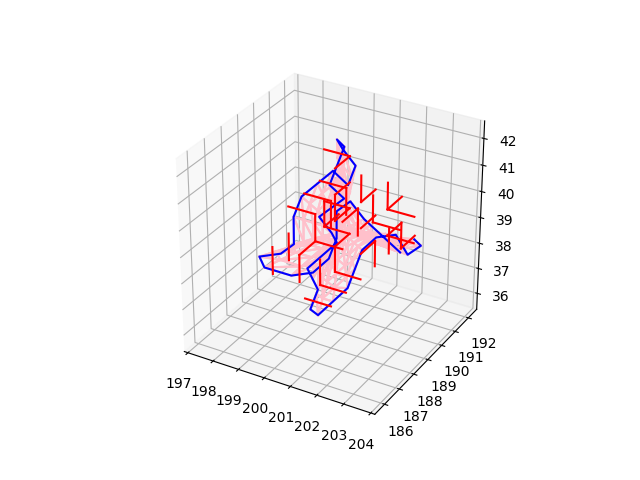

In [86]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')

X = []
Y = []
Z = []


# Draw loop of points
for point in points(cycle).points:
    x, y, z = point
    X.append(x)
    Y.append(y)
    Z.append(z)



for triangle in triangles:
    for i in range(3):
        x1,y1,z1 = mapping[triangle[i]]
        x2,y2,z2 = mapping[triangle[(i+1)%3]]
        ax.plot([x1,x2],[y1,y2],[z1,z2],color='pink')

ax.plot(X, Y, Z, color='b')

# for edge in Edges:
#     ax.plot([edge[0][0],edge[1][0]],[edge[0][1],edge[1][1]],[edge[0][2],edge[1][2]],color='black')
    

for edge in Marked_edges:
    ax.plot([edge[0][0],edge[1][0]],[edge[0][1],edge[1][1]],[edge[0][2],edge[1][2]],color='red')

X,Y,Z = np.array(X),np.array(Y),np.array(Z)
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0 

mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

plt.show()


In [78]:

len(Marked_edges)

44

In [18]:
len(Edges)

51

## Gurobi Model

## Filling the MIP for problem constraints

In [9]:
import pulp 
from pulp import GUROBI_CMD
solver_list = pulp.listSolvers(onlyAvailable=True)
print(solver_list)

Restricted license - for non-production use only - expires 2025-11-24
['GLPK_CMD', 'GUROBI', 'PULP_CBC_CMD']


In [69]:
from gurobipy import Model, GRB, quicksum
import numpy as np

def resolve_MIP(cycles, Blocked_edges, Marked_edges, one_by_one=True):
    GC = Graph_Cycles(Blocked_edges, Marked_edges)
    G = GraphGrid3D(Blocked_edges, [])

    # Create a new model
    model = Model("Graph Problem")

    # Suppress Gurobi solver output
    model.setParam('OutputFlag', 0)

    # Define the decision variables
    x = model.addVars(G.edges, vtype=GRB.BINARY, name="x")

    # Define the objective function
    model.setObjective(quicksum(x[i] for i in G.edges), GRB.MINIMIZE)

    def add_initial_constraints(model, GC, cycles):
        if GC.b_1:
            if one_by_one:
                L = [len(cycle) for cycle in GC.b_1]
                if L:  # Ensure L is not empty
                    indice1 = np.argmin(L)
                    cycle1 = list(GC.b_1)[indice1]
                    cycles.append(cycle1)
                    
            else:
                n_cycles = [c for c in list(GC.b_1) if len(c) == 5]
                for c in n_cycles:
                    cycles.append(c)
            
            E = []
            for cycle in cycles:
                edges = []
                for point in range(len(cycle) - 1):
                    node = cycle[point]
                    next_node = cycle[(point + 1)]
                    edge = (min(node, next_node), max(node, next_node))
                    edges.append(edge)
                E.append(edges)

            for edge in E:
                model.addConstr(quicksum(x[i] for i in edge) >= 1)


    # Add initial constraints
    add_initial_constraints(model, GC, cycles)

    # Set the LazyConstraints parameter
    model.Params.LazyConstraints = 1

    # Define a callback function for constraint separation
    def my_callback(model, where):
        if where == GRB.Callback.MIPSOL:
            new_cycles = Graph_Cycles(Blocked_edges, Marked_edges).b_1
            for cycle in new_cycles:
                edges = []
                for point in range(len(cycle) - 1):
                    node = cycle[point]
                    next_node = cycle[(point + 1)]
                    edge = (min(node, next_node), max(node, next_node))
                    edges.append(edge)
                if sum(model.cbGetSolution(x[i]) for i in edges) < 1:
                    model.cbLazy(quicksum(x[i] for i in edges) >= 1)

    # Optimize the model with lazy constraints callback
    model.optimize(my_callback)

    # Debugging: Check the model status
    if model.Status != GRB.OPTIMAL:
        print("Model did not find an optimal solution")
        return cycles, []

    # Print the optimal solution
    new_marked = []
    for i in G.edges:
        if x[i].X == 1:
            n, m = i
            new_marked.append([G.mapping[n], G.mapping[m]])

    # Print the objective value
    
    return cycles, new_marked

# Assuming the required classes and functions such as Graph_Cycles, GraphGrid3D, etc., are defined elsewhere

Blocked_edges = Edges  # Replace with your actual edges
Marked_edges = []
cycles = []
GC = Graph_Cycles(Blocked_edges, Marked_edges)
cpt = 0
while GC.b_1: 
    if cpt % 5 == 0:
        print(len(Marked_edges),len(GC.b_1),len(cycles))
    cpt += 1
    GC = Graph_Cycles(Blocked_edges, Marked_edges)
    cycles, new_marked = resolve_MIP(cycles, Blocked_edges, Marked_edges, one_by_one=False)
    if new_marked == []:
        break
    Marked_edges = new_marked
print("Marked edges after iteration:", Marked_edges)


0 115 0
19 147 23
18 153 23
19 147 23
18 153 23

Interrupt request received
Model did not find an optimal solution
Marked edges after iteration: [[(180, 124, 46), (180, 125, 46)], [(180, 123, 50), (181, 123, 50)], [(180, 123, 51), (181, 123, 51)], [(180, 124, 49), (181, 124, 49)], [(181, 125, 44), (181, 126, 44)], [(180, 132, 45), (181, 132, 45)], [(181, 124, 50), (181, 124, 51)], [(180, 131, 45), (180, 131, 46)], [(180, 131, 49), (181, 131, 49)], [(180, 125, 45), (181, 125, 45)], [(180, 131, 51), (181, 131, 51)], [(180, 132, 47), (181, 132, 47)], [(180, 128, 50), (181, 128, 50)], [(180, 129, 46), (181, 129, 46)], [(180, 123, 48), (181, 123, 48)], [(180, 126, 50), (181, 126, 50)], [(180, 133, 46), (181, 133, 46)], [(180, 130, 50), (181, 130, 50)], [(180, 127, 46), (181, 127, 46)]]


In [70]:
Marked

[(array([180, 125,  47]), array([181, 125,  47])),
 (array([180, 125,  46]), array([181, 125,  46])),
 (array([180, 126,  44]), array([181, 126,  44])),
 (array([180, 132,  45]), array([181, 132,  45])),
 (array([180, 133,  46]), array([181, 133,  46])),
 (array([180, 132,  46]), array([181, 132,  46])),
 (array([180, 131,  47]), array([181, 131,  47])),
 (array([180, 131,  48]), array([181, 131,  48])),
 (array([180, 131,  49]), array([181, 131,  49])),
 (array([180, 132,  50]), array([181, 132,  50])),
 (array([180, 131,  50]), array([181, 131,  50])),
 (array([180, 129,  51]), array([181, 129,  51])),
 (array([180, 127,  50]), array([181, 127,  50])),
 (array([180, 126,  50]), array([181, 126,  50])),
 (array([180, 125,  49]), array([181, 125,  49])),
 (array([180, 123,  51]), array([181, 123,  51])),
 (array([180, 123,  50]), array([181, 123,  50])),
 (array([180, 124,  49]), array([181, 124,  49])),
 (array([180, 123,  48]), array([181, 123,  48])),
 (array([180, 126,  46]), array

In [74]:
import gurobipy as gp


GC = Graph_Cycles(Blocked_edges, Marked_edges)
G = GraphGrid3D(Blocked_edges, [])

# Create a new model
model = Model("Graph Problem")

# Suppress Gurobi solver output
model.setParam('OutputFlag', 0)

# Define the decision variables
x = model.addVars(G.edges, vtype=GRB.BINARY, name="x")

# Define the objective function
model.setObjective(quicksum(x[i] for i in G.edges), GRB.MINIMIZE)

# Function to add lazy constraints
def add_cycle_constraints(model, GC):
    while GC.b_1:
        # Get the smallest cycle in GC.b_1
        smallest_cycle = min(GC.b_1, key=len)
        edges_in_cycle = []
        for i in range(len(smallest_cycle) - 1):
            node, next_node = smallest_cycle[i], smallest_cycle[i + 1]
            edge = (min(node, next_node), max(node, next_node))
            edges_in_cycle.append(edge)
        
        # Add a lazy constraint to ensure at least one edge in the cycle is selected
        model.addConstr(gp.quicksum(x[edge] for edge in edges_in_cycle) >= 1)
        
        # Solve the model again
        model.optimize()
        
        # Check the new solution
        if model.status == GRB.OPTIMAL:
            # Update Marked_edges based on the current solution
            new_marked = []
            for edge in G.edges:
                if x[edge].X > 0.5:
                    new_marked.append([G.mapping[edge[0]], G.mapping[edge[1]]])
            
            # Update the graph cycles with the new marked edges
            print(len(new_marked),len(GC.b_1),len(cycles))
            GC = Graph_Cycles(Blocked_edges, new_marked)
        else:
            break

# Initialize Graph_Cycles object
GC = Graph_Cycles(Blocked_edges, Marked_edges)

# Optimize the model without lazy constraints first
model.optimize()

# Add cycle constraints until GC.b_1 is empty
add_cycle_constraints(model, GC)

# Print the final solution
if model.status == GRB.OPTIMAL:
    print("Optimal solution found:")
    for edge in G.edges:
        if x[edge].X > 0.5:
            print(f"Edge {edge} selected")
else:
    print("No optimal solution found.")

1 153 23
1 115 23
2 113 23
3 112 23
3 118 23
4 116 23
5 179 23
6 135 23
7 139 23
8 113 23
9 181 23
10 93 23
11 97 23
11 95 23
12 107 23
13 83 23
14 253 23
15 107 23
15 106 23
15 104 23
15 155 23
16 121 23
17 144 23
18 102 23
18 190 23
18 173 23
18 147 23
18 102 23
18 94 23
18 145 23
19 163 23
20 148 23
21 141 23
21 163 23
21 99 23
21 248 23
21 248 23
21 142 23
21 142 23
21 142 23
21 142 23
21 158 23
22 136 23
22 187 23
23 146 23
23 140 23
23 150 23
23 151 23
24 101 23
24 148 23
24 153 23
25 155 23
25 153 23
25 152 23
25 150 23
26 148 23
26 71 23
26 137 23
26 146 23
26 115 23
26 151 23
26 56 23
26 56 23
27 226 23
27 57 23
27 104 23
27 56 23
28 104 23
28 113 23
28 104 23
28 133 23
28 140 23
28 139 23
28 149 23
28 151 23
28 145 23
28 138 23
28 138 23
29 124 23
29 143 23
29 47 23
29 180 23
29 132 23
29 207 23
30 114 23
30 139 23
30 55 23
30 140 23
30 133 23
31 132 23
31 142 23
31 52 23
31 110 23
31 111 23
31 140 23
31 116 23
31 134 23
31 144 23
32 110 23
32 209 23
32 227 23
32 162 23
32 16

In [84]:
Marked_edges = []

            

Optimal solution found:


In [1]:
from gurobipy import Model, GRB, quicksum
import numpy as np

def resolve_MIP(cycles, Blocked_edges, Marked_edges, one_by_one=True):
    GC = Graph_Cycles(Blocked_edges, Marked_edges)
    G = GraphGrid3D(Blocked_edges, [])

    # Create a new model
    model = Model("Graph Problem")

    # Suppress Gurobi solver output
    model.setParam('OutputFlag', 0)

    # Define the decision variables
    x = model.addVars(G.edges, vtype=GRB.BINARY, name="x")

    # Define the objective function
    model.setObjective(quicksum(x[i] for i in G.edges), GRB.MINIMIZE)

    def add_initial_constraints(model, GC, cycles):
        if GC.b_1:
            if one_by_one:
                L = [len(cycle) for cycle in GC.b_1]
                if L:  # Ensure L is not empty
                    indice1 = np.argmin(L)
                    cycle1 = list(GC.b_1)[indice1]
                    cycles.append(cycle1)
            else:
                n_cycles = [c for c in list(GC.b_1) if len(c) == 5]
                for c in n_cycles:
                    cycles.append(c)

            E = []
            for cycle in cycles:
                edges = []
                for point in range(len(cycle)):
                    node = cycle[point]
                    next_node = cycle[(point + 1) % len(cycle)]
                    edge = (min(node, next_node), max(node, next_node))
                    if node != next_node:  # Ensure no self-loops
                        edges.append(edge)
                E.append(edges)

            for edge in E:
                model.addConstr(quicksum(x[i] for i in edge) >= 1)

    # Add initial constraints
    add_initial_constraints(model, GC, cycles)

    # Set the LazyConstraints parameter
    model.Params.LazyConstraints = 1

    # Define a callback function for constraint separation
    def my_callback(model, where):
        if where == GRB.Callback.MIPSOL:
            new_cycles = Graph_Cycles(Blocked_edges, Marked_edges).b_1
            for cycle in new_cycles:
                edges = []
                for point in range(len(cycle)):
                    node = cycle[point]
                    next_node = cycle[(point + 1) % len(cycle)]
                    edge = (min(node, next_node), max(node, next_node))
                    if node != next_node:  # Ensure no self-loops
                        edges.append(edge)
                if sum(model.cbGetSolution(x[i]) for i in edges) < 1:
                    model.cbLazy(quicksum(x[i] for i in edges) >= 1)

    # Optimize the model with lazy constraints callback
    model.optimize(my_callback)

    # Debugging: Check the model status
    if model.Status != GRB.OPTIMAL:
        print("Model did not find an optimal solution")
        return cycles, []

    # Print the optimal solution
    new_marked = []
    for i in G.edges:
        if x[i].X == 1:
            n, m = i
            new_marked.append([G.mapping[n], G.mapping[m]])

    return new_marked

# Assuming the required classes and functions such as Graph_Cycles, GraphGrid3D, etc., are defined elsewhere

Blocked_edges = Edges  # Replace with your actual edges
Marked_edges = []
cycles = []
GC = Graph_Cycles(Blocked_edges, Marked_edges)
cpt = 0
while GC.b_1: 
    if cpt % 5 == 0:
        print(len(Marked_edges), len(GC.b_1), len(cycles))
    cpt += 1
    GC = Graph_Cycles(Blocked_edges, Marked_edges)
    cycles, new_marked = resolve_MIP(cycles, Blocked_edges, Marked_edges, one_by_one=False)
    if new_marked == []:
        break
    Marked_edges = new_marked

print("Marked edges after iteration:", Marked_edges)


NameError: name 'Edges' is not defined

In [18]:
New_marked = resolve_MIP(cycles, Blocked_edges, [], one_by_one=False)
len(New_marked[1])

29

In [121]:
change(cycle)
print(cycle)

[0, 1, 0, 1, 0, 1]


In [11]:
import cProfile
import pstats


profiler = cProfile.Profile()
profiler.enable()
# Marked_edges = []
# Blocked_edges = Edges  # Replace with your actual edges
# Marked_edges = []
# cycles = []
# GC = Graph_Cycles(Blocked_edges, Marked_edges)
# cpt = 1
while GC.b_1:
    
    if cpt % 10 == 0:
        print(len(Marked_edges),len(GC.b_1),len(cycles))
    cpt += 1
    GC = Graph_Cycles(Blocked_edges, Marked_edges)
    cycles, new_marked = resolve_MIP(cycles, Blocked_edges, Marked_edges, one_by_one=True)
    if new_marked == []:
        break
    Marked_edges = new_marked
profiler.disable()
stats = pstats.Stats(profiler).sort_stats('cumulative')
stats.print_stats()

20 143 32
22 138 42
24 148 52
27 128 62
29 138 72
29 109 82

Interrupt request received
Model did not find an optimal solution
         87942258 function calls (87759132 primitive calls) in 29.984 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000   30.058   15.029 /home/mehdii/projects/def-vidalthi/mehdii/3DPU_Plateau_Problem/env_gurobi_HZ/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3541(run_code)
        2    0.000    0.000   30.058   15.029 {built-in method builtins.exec}
       67    1.468    0.022   27.194    0.406 /tmp/ipykernel_56065/105285183.py:4(resolve_MIP)
     8628    2.142    0.000   22.451    0.003 /tmp/ipykernel_56065/105285183.py:55(my_callback)
      528    0.225    0.000   21.986    0.042 /home/mehdii/projects/def-vidalthi/mehdii/3DPU_Plateau_Problem/MIP_constraints/Python/CreatingCycles.py:6(__init__)
   419562    8.322    0.000   13.318    0.000 /home/mehdii/

In [22]:
GC = Graph_Cycles(Edges, [])
len(GC.cycles)
Marked_edges[0:1]

[[(180, 131, 47), (181, 131, 47)]]

In [59]:
G0 = GraphGrid3D(Edges,[])
print(len(G0.edges))
basis_graph0 = nx.Graph()
basis_graph0.add_edges_from(G0.edges)
basis0 = nx.cycle_basis(basis_graph0)
print(len(basis0))

G1 = GraphGrid3D(Edges,Marked_edges)
print(len(G1.edges))
basis_graph1 = nx.Graph()
basis_graph1.add_edges_from(G1.edges)
basis1 = nx.cycle_basis(basis_graph1)
print(len(basis1))

1338
819
1296
777


In [60]:
edges_basis_ = set()
for basis in basis1:
    edges_basis = [(min(basis[i],basis[(i+1)%len(basis)]),max(basis[i],basis[(i+1)%len(basis)])) for i in range(len(basis)-1)]
    for edge in edges_basis:
        edges_basis_.add(edge)

len(edges_basis_),len(basis_graph1.edges)


(1239, 1296)

In [24]:
from gurobipy import Model, GRB, quicksum

def lazy_constraint_example():
    # Create a new model
    model = Model("lazy_constraints_example")

    # Create variables
    x = model.addVar(vtype=GRB.BINARY, name="x")
    y = model.addVar(vtype=GRB.BINARY, name="y")

    # Set objective
    model.setObjective(x + y, GRB.MAXIMIZE)

    # Add initial constraints (base constraints)
    model.addConstr(x + 2*y <= 3, "InitialConstraint")
    model.Params.LazyConstraints = 1

    # Define the lazy constraint (example constraint: x + y <= 1.5)
    def lazy_callback(model, where):
        if where == GRB.Callback.MIPSOL:
            x_val = model.cbGetSolution(x)
            y_val = model.cbGetSolution(y)
            if x_val + y_val > 1.5:  # Example lazy constraint condition
                model.cbLazy(x + y <= 1.5)

    # Optimize the model with lazy constraints
    model.optimize(lazy_callback)

    # Print the results
    for v in model.getVars():
        print(f'{v.varName}: {v.x}')

    print(f'Objective Value: {model.objVal}')

# Run the example
lazy_constraint_example()

Set parameter LazyConstraints to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Rocky Linux 8.9 (Green Obsidian)")

CPU model: AMD EPYC 7532 32-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 64 physical cores, 64 logical processors, using up to 32 threads

Optimize a model with 1 rows, 2 columns and 2 nonzeros
Model fingerprint: 0x6455b04b
Variable types: 0 continuous, 2 integer (2 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 3e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.03s
Presolved: 0 rows, 2 columns, 0 nonzeros
Variable types: 0 continuous, 2 integer (2 binary)

Root relaxation: objective 1.000000e+00, 0 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0        

(1.0, 5.0)

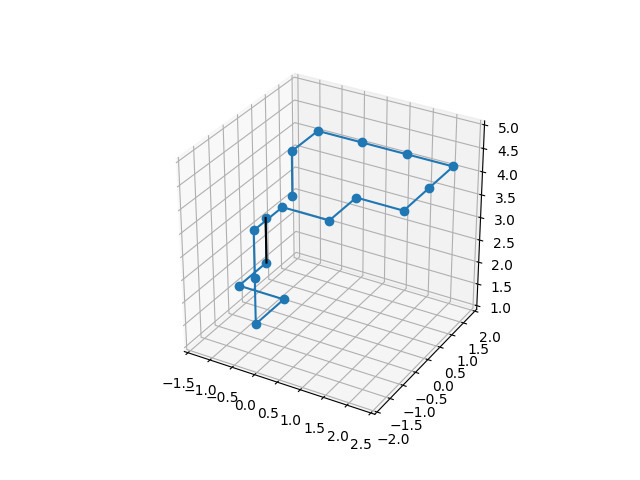

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')
X,Y,Z = [],[],[]
cpt1 = np.random.randint(0,len(GC.dict_blocked_edges))
blocked_edge = list(GC.dict_blocked_edges.keys())[cpt1]
cycle_blocked = GC.dict_blocked_edges[blocked_edge]
cycle = cycle_blocked[np.random.randint(0,len(cycle_blocked))]
# for cycle in GC.dict_blocked_edges[(62, 63)]:
A,B,C = [],[],[]
for point in cycle:
    x, y, z = G.mapping[point]
    A.append(x)
    B.append(y)
    C.append(z)
    ##########
    X.append(x)
    Y.append(y)
    Z.append(z)

ax.plot(A, B, C,marker = "o") 

Blockii_edges = []
for i in range(len(cycle)):
    edge = min(cycle[i],cycle[(i+1)%len(cycle)]),max(cycle[i],cycle[(i+1)%len(cycle)])
    if edge in G.blocked_edges:
        Blockii_edges.append(edge)
    
for edge in Blockii_edges:
    x,y,z = G.mapping[edge[0]]
    x1,y1,z1 = G.mapping[edge[1]]
    ax.plot([x,x1],[y,y1],[z,z1],color="black")


# origin = 180
# x,y,z = G.mapping[origin]
# ax.plot(x,y,z,color="black",marker="x")

X,Y,Z = np.array(X),np.array(Y),np.array(Z)
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0 

mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

## Resolving the MIP problem

In [9]:
import pulp

# Create a MIP problem
def resolve_MIP(cycles,Blocked_edges,Marked_edges):
    problem = pulp.LpProblem("Graph Problem", pulp.LpMinimize)
    GC = Graph_Cycles(Blocked_edges,Marked_edges)
    G = GraphGrid3D(Blocked_edges,[])
    # Define the decision variables
    x = pulp.LpVariable.dicts("x", G.edges, cat=pulp.LpBinary)

    # Define the objective function
    problem += pulp.lpSum([x[i] for i in G.edges])

    # detect a constraints
    cycle = find_cycle_impair(GC)
    cycles.append(cycle)
    E = []
    for cycle in cycles:
        edges = []
        for point in range(len(cycle)-1):
            node = cycle[point]
            next_node = cycle[(point+1)]
            edge = (min(node,next_node),max(node,next_node))
            edges.append(edge)
        E.append(edges)

    for edge in E:

        problem += pulp.lpSum(x[i] for i in edge) >= 1

    # Solve the MIP problem
    problem.solve(pulp.PULP_CBC_CMD())
    
    # Print the optimal solution
    print("Optimal Solution:")
    new_marked = []
    for i in G.edges:
        if pulp.value(x[i]) == 1:
            print(i)
            n,m = i
            new_marked.append([G.mapping[n],G.mapping[m]])
    # Print the objective value
    print("Objective Value:", pulp.value(problem.objective))
    return cycles,new_marked



In [53]:
GC = Graph_Cycles(Edges,[])
len(GC.dict_blocked_edges)

100%|██████████| 749/749 [00:00<00:00, 2284.14it/s]


25

## Debuggage

In [5]:
import pickle

# Pickle Edges
with open('edges.pickle', 'rb') as f:
    Edges = pickle.load(f)


In [6]:
def find_cycle_impair(GC):
    path = nx.shortest_path(GC.Graph_cycles,0,1)
    tried_paths = set()
    while not GC.get_full_cycle(path) and tuple(path) not in tried_paths:
        cpt1 = np.random.randint(0,len(GC.dict_blocked_edges))
        blocked_edge = list(GC.dict_blocked_edges.keys())[cpt1]
        cycle_blocked = GC.dict_blocked_edges[blocked_edge]
        if len(cycle_blocked) == 0:
            print("---------------------")
            print(cpt1)
            print("--------------------")
        cycle_blocked_index = GC.cycles_index[cycle_blocked[np.random.randint(0,len(cycle_blocked))]]
        cycle_index = np.random.randint(0,len(GC.cycles))
        tried_paths.add(tuple(path))
        path = nx.shortest_path(GC.Graph_cycles,cycle_index,cycle_blocked_index)
    return GC.get_full_cycle(path)

26

In [ ]:
def find_impair_cycle(GC):
    
    for path in GC.

In [25]:
Marked_edges = [[(-2, 0, 0), (-2, 0, 1)], [(0, -2, 2), (0, -1, 2)], [(1, 1, -1), (2, 1, -1)], [(1, -2, 2), (1, -1, 2)], [(2, 0, 0), (2, 0, 1)], [(1, 1, 2), (1, 1, 3)], [(-2, 0, 3), (-1, 0, 3)], [(-1, 2, 2), (-1, 2, 3)], [(0, 3, 2), (0, 3, 3)], [(-1, -1, 1), (-1, -1, 2)], [(-3, 3, 1), (-2, 3, 1)], [(2, 0, 2), (2, 0, 3)], [(1, -3, 2), (1, -3, 3)], [(1, -1, 4), (1, 0, 4)], [(2, 1, 2), (2, 1, 3)], [(-2, -1, 4), (-1, -1, 4)], [(3, -3, -1), (3, -3, 0)], [(1, 1, 0), (1, 1, 1)], [(-2, -1, 3), (-1, -1, 3)], [(-1, -2, 0), (0, -2, 0)]]


In [26]:
GC = Graph_Cycles(Edges,Marked_edges)
G = GraphGrid3D(Edges,[])
cycle = find_cycle_impair(GC)

 64%|██████▍   | 467/729 [00:00<00:00, 2260.69it/s]

100%|██████████| 729/729 [00:00<00:00, 1787.85it/s]


(-1.0, 4.0)

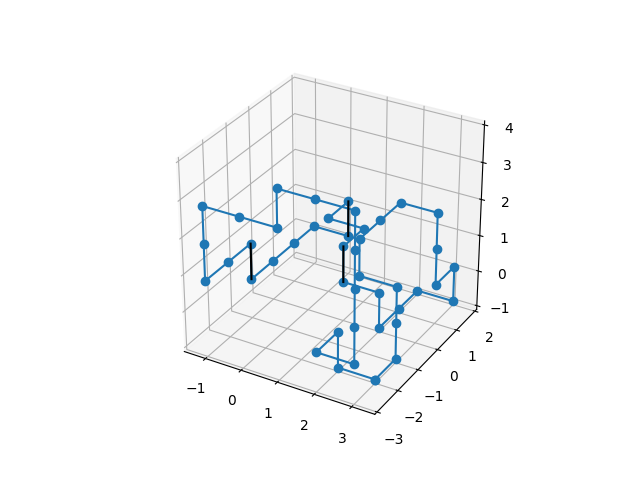

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')
X,Y,Z = [],[],[]

# for cycle in GC.dict_blocked_edges[(62, 63)]:
A,B,C = [],[],[]
for point in cycle:
    x, y, z = G.mapping[point]
    A.append(x)
    B.append(y)
    C.append(z)
    ##########
    X.append(x)
    Y.append(y)
    Z.append(z)

ax.plot(A, B, C,marker = "o") 

Blockii_edges = []
for i in range(len(cycle)):
    edge = min(cycle[i],cycle[(i+1)%len(cycle)]),max(cycle[i],cycle[(i+1)%len(cycle)])
    if edge in G.blocked_edges:
        Blockii_edges.append(edge)
    
for edge in Blockii_edges:
    x,y,z = G.mapping[edge[0]]
    x1,y1,z1 = G.mapping[edge[1]]
    ax.plot([x,x1],[y,y1],[z,z1],color="black")


# origin = 180
# x,y,z = G.mapping[origin]
# ax.plot(x,y,z,color="black",marker="x")

X,Y,Z = np.array(X),np.array(Y),np.array(Z)
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0 

mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

In [48]:
G = GraphGrid3D(Edges,[])
GC = Graph_Cycles(Edges,Marked_edges)

100%|██████████| 600/600 [00:00<00:00, 3724.61it/s]
